In [16]:
import numpy as np
import numpy.linalg as LA
from sklearn.utils import murmurhash3_32
from random import randint
import matplotlib.pyplot as plt
import stats
import copy
import time
import multiprocessing
from scipy.special import factorial
import math
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import binom
from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import mvn
from scipy.optimize import fsolve
from os.path import dirname, abspath, join
from datasets import get_dataset, get_dataset_path
import argparse
import pickle

In [17]:
def hashfunc(m):
    ss = randint(1, 99999999)
    def hash_m(x):
        return murmurhash3_32(x,seed=ss)%m
    return hash_m


class count_sketch():
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.table = np.zeros((n,k))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        self.table[loc,np.arange(self.k)] += item * sign
        self.item_count += 1
        
    def insert_ID_list(self, item, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        for i in range(loc_array.shape[0]):      
            self.table[loc_array[i],np.arange(self.k)] += item[i] * sign_array[i]
        
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        return np.median(items)
    
    def retrieve_ID_list(self, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        item_array = self.table[loc_array.flatten(), np.tile(np.arange(self.k), loc_array.shape[0])]
        item_array = item_array.reshape(loc_array.shape) * sign_array
        return np.median(item_array, axis = 1)
    
    def retrieve_item_list(self, index, VAR = False):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        if VAR:
            item_var = np.var(np.sort(item_list)[3:(self.k-3)])
            return items, item_var
        else:
            return items
    
#     def retrieve_var(self, index):
#         loc = np.array([self.hash_func[k](index) for k in range(self.k)])
#         sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
#         items = self.table[loc,np.arange(self.k)]*sign
#         return np.var(items)
    
    def clean():
        self.table = np.zeros((n,k))
        self.item_count = 0

        
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [18]:
DATA_PATH = './gisette/gisette_scale.bz2'
data = get_dataset_path(DATA_PATH)[0].toarray()

NUM_FEATURES_ORIGIN = 2000
NUM_SAMPLES_ORIGIN = data.shape[0]
## Split 1000 samples to filter the sparse features and 
## evaluate the standard deviation of the variables
NUM_SAMPLES_EXPLORE = 200
NUM_SAMPLES = 5000

In [19]:
num_features = data.shape[1]
num_samples = data.shape[0]
features = np.random.randint(0, num_features, NUM_FEATURES_ORIGIN)
samples = np.random.randint(0, num_samples, NUM_SAMPLES_ORIGIN)
data = data[samples[:,None],features]

# mean_obs = np.apply_along_axis(np.mean, 0, data)
# # var_obs = (data - mean_obs).T@(data - mean_obs)/num_samples
# var_obs = data.T @ data / num_samples

In [20]:
## use 1000 samples to filter the sparse features
sparsity = (data[0:NUM_SAMPLES_EXPLORE,:] > 0)*1
abundant_feature = np.apply_along_axis(np.sum, 0, sparsity)
data = data[NUM_SAMPLES_EXPLORE:(NUM_SAMPLES_ORIGIN),abundant_feature>=10]

## data_sample uses 1000 samples to evaluate the standard deviation of the variables
data_sample = data[0:NUM_SAMPLES_EXPLORE,:]

## Number of features left
NUM_FEATURES = data.shape[1]

In [105]:
with open('./gisette/results/sampled_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Determine the exploration period and thresholds

In [21]:
def miss_prop_at_t(x, n, R, k, sigma, signal, alpha, T, t):
    order_expect = -norm.ppf(((k - 1) / 2 - 0.375) / (k + 1 - 2 * 0.375))
    sigma_x = sigma * np.sqrt(1 / t + math.pi * (n - 1) * (1 - alpha) / (2 * k * t * (R - alpha)))
    percentile_1 = -x / sigma_x
    percentile_2 = -(x / sigma_x - order_expect)
    p = 0.5 + 0.5 * ((R - alpha) / R) ** (n - 1)
    prob_1 = p ** k
    prob_2 = k * (1 - p) * p ** (k - 1)

    return prob_1 * norm.cdf(percentile_1) + prob_2 * norm.cdf(percentile_2) + (1 - prob_1 - prob_2)


def miss_prop_after_t(theta, Tau, n, R, k, sigma, signal, alpha, T, t):
    order_expect = -norm.ppf((k / 2 - 0.375) / (k + 1 - 2 * 0.375))
    var = math.pi * (n - 1) * (1 - alpha) * sigma ** 2 / (2 * k * (R - alpha))

    nu_0 = t / T * signal
    nu_1 = (signal - theta) / T
    nu_0_tilde = t / T * (signal - order_expect * np.sqrt(var / t))
    nu_1_tilde = 1 / T * (signal - theta - order_expect * np.sqrt(var) * (np.sqrt(t + 1) - np.sqrt(t)))

    omega_0 = np.sqrt(t / T ** 2 * (1 + var))
    omega_1 = omega_0 / np.sqrt(t)
    omega_0_tilde = omega_0
    omega_1_tilde = omega_1

    a1 = np.exp(-nu_0 ** 2 / (2 * omega_0 ** 2) + 2 * Tau * nu_1 / omega_1 ** 2 + (
                nu_0 - 2 * nu_1 * omega_0 ** 2 / omega_1 ** 2) ** 2 / (2 * omega_0 ** 2)) * \
         norm.cdf(((nu_0 - 2 * nu_1 * omega_0 ** 2 / omega_1 ** 2) - Tau) / omega_0)

    a2 = np.exp(-nu_0 ** 2 / (2 * omega_0_tilde ** 2) + 2 * Tau * nu_1_tilde / omega_1_tilde ** 2 +
                (nu_0_tilde - 2 * nu_1_tilde * omega_0_tilde ** 2 / omega_1_tilde ** 2) ** 2 / (
                            2 * omega_0_tilde ** 2)) * \
         norm.cdf(((nu_0_tilde - 2 * nu_1_tilde * omega_0_tilde ** 2 / omega_1_tilde ** 2) - Tau) / omega_0_tilde)

    p = 0.5 + 0.5 * ((R - alpha) / R) ** (n - 1)
    prob_1 = p ** k
    prob_2 = k * (1 - p) * p ** (k - 1)

    return a1 * prob_1 + a2 * prob_2


In [26]:
n = NUM_FEATURES * (NUM_FEATURES-1) / 2
R = 20000
alpha = 5*10**(-3)
exploration_period = 500
T = NUM_SAMPLES
target_signal = 0.6
sigma = np.sqrt(1.36)
k = 5

Tau = 0.01

print('prob at T_0: ', miss_prop_at_t(target_signal-Tau*T/exploration_period, n, R, k, sigma, target_signal, alpha, T, exploration_period))

theta = 0.544
print('prob during sampling: ', miss_prop_after_t(theta, Tau, n, R, k, sigma, target_signal, alpha, T, exploration_period))

prob at T_0:  0.059281593506469776
prob during sampling:  0.18617464464984418


## Experiments

In [6]:
mean_obs = np.apply_along_axis(np.mean, 0, data)
var_obs = (data - mean_obs).T @ (data - mean_obs) / NUM_SAMPLES
cor_obs = correlation_from_covariance(var_obs)
var_diag = np.diag(var_obs)
var_off_diag = var_obs[np.triu_indices(NUM_FEATURES, k=1)]
cor_off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)]

mean_obs_sample = np.apply_along_axis(np.mean, 0, data_sample)
var_obs_sample = (data_sample - mean_obs).T @ (data_sample - mean_obs) / data_sample.shape[0]
var_diag_sample = np.diag(var_obs_sample)
var_off_diag_sample = var_obs_sample[np.triu_indices(NUM_FEATURES, k=1)]


ID = [x for x in range(len(var_off_diag))]
ID = np.array([str(x) for x in ID])

/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


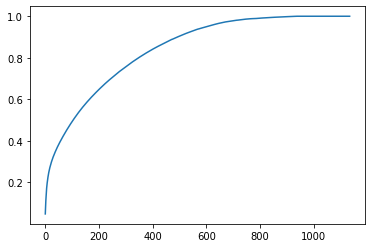

In [12]:
plt.plot(np.cumsum(s)/sum(s))

In [134]:
## Number of signal variables
np.sum(np.abs(cor_off_diag)>0.6), len(cor_off_diag)

(1241, 613278)

In [135]:
data_norm = (data - mean_obs_sample[None,:]) / np.sqrt(var_diag_sample)[None,:]

batch_size = 100
block_end = list(np.arange(exploration_period, NUM_SAMPLES, batch_size)) + [NUM_SAMPLES]
block_start = [0] + block_end[:-1]


CS_RANGE = 20000
CS_REP = 5

sketch = count_sketch(CS_RANGE, CS_REP)
sketch.clean

for i, (start, end) in enumerate(zip(block_start, block_end)):
    data_batch = data_norm[start:end,:]
    var_batch = data_batch.T @ data_batch / NUM_SAMPLES
    var_off_diag_batch = var_batch[np.triu_indices(NUM_FEATURES, k=1)]
    
    ## Filtering
    if (i > 0):
        var_off_diag_batch = var_off_diag_batch[index_retain]
        ID_retain = np.array(ID)[index_retain]     
    else:
        index_retain = (np.ones(len(ID))>0)
        ID_retain = ID
    
    ## Insertion
    sketch.insert_ID_list(var_off_diag_batch, ID_retain)
    
    ## Retrieve
    var_off_diag_2 = sketch.retrieve_ID_list(ID)
    
    ## 
    sample_threshold = Tau + theta*i/NUM_SAMPLES*batch_size
    index_retain = (np.abs(var_off_diag_2) > sample_threshold)
    
    if (end==exploration_period) or (end % 200 == 0):
        print(end, round(sample_threshold, 5), np.sum(index_retain), 
              np.sum(index_retain*(cor_off_diag>target_signal)))
        
        
with open('./gisette/results/CS_estimate(designed signal=%f).pickle' %target_signal, 'wb') as handle:
    pickle.dump(var_off_diag_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

500 0.01 441569 1218
600 0.02088 315973 1209
800 0.04264 181829 1193
1000 0.0644 115573 1186
1200 0.08616 81009 1178
1400 0.10792 59806 1174
1600 0.12968 46961 1174
1800 0.15144 38123 1174
2000 0.1732 31235 1172
2200 0.19496 26692 1173
2400 0.21672 23193 1170
2600 0.23848 20780 1170
2800 0.26024 19129 1171
3000 0.282 17404 1170
3200 0.30376 16018 1169
3400 0.32552 14859 1170
3600 0.34728 13804 1169
3800 0.36904 12878 1168
4000 0.3908 12340 1168
4200 0.41256 11737 1166
4400 0.43432 11083 1166
4600 0.45608 10656 1168
4800 0.47784 10141 1166
5000 0.4996 9769 1166


Best F1 Score:  0.5310290652003142


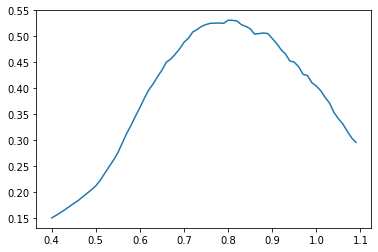

In [136]:
off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)] 

F1_score = []
precision_list = []
recall_list = [] 


threshold_list = np.arange(0.4, 1.1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>target_signal)
    predict_positive_index = (np.abs(var_off_diag_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]
    
    
print('Best F1 Score: ', np.max(F1_score))

plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

# plt.plot(1 - np.array(precision_list), np.array(recall_list))
# plt.xlabel('1 - Precision')
# plt.ylabel('Recall')
# plt.show()

In [138]:
max_F1_score_list = []

signal_list = np.arange(0.3, 0.7, 0.01)

for signal in signal_list:
    max_F1_score = 0
    for thres in np.arange(signal-0.1, signal+0.4, 0.01):
        positive_index = (np.abs(off_diag)>signal)
        predict_positive_index = (np.abs(var_off_diag_2)>thres)
        fn = np.sum(positive_index*(1-predict_positive_index))
        tp = np.sum(predict_positive_index*positive_index)
        
        if np.sum(predict_positive_index) > 0:
            precision = tp/np.sum(predict_positive_index)
        else:
            precision = 0
        recall = tp/(tp+fn)

        ## Deviation from the true covariance matrix
        max_F1_score = max(max_F1_score, 2*precision*recall/(precision+recall))
    max_F1_score_list += [max_F1_score]
    
# plt.plot(signal_list, max_F1_score_list)
# plt.show()


with open('./gisette/results/max_F1_score_list(designed signal=%f).pickle' %target_signal, 'wb') as handle:
    pickle.dump(max_F1_score_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Conventional Count Sketch

In [95]:
CS_RANGE = 20000
CS_REP = 5

sketch = count_sketch(CS_RANGE, CS_REP)
sketch.clean

cor_off_diag = (data_norm.T @ data_norm / NUM_SAMPLES)[np.triu_indices(NUM_FEATURES, k=1)]

for item, mem_id in zip(cor_off_diag, ID):
    sketch.insert(item, mem_id)

var_off_diag_3 = []
CMS_var = []
for mem_id in ID:
    var_off_diag_3 += [sketch.retrieve(mem_id)]
    
# var_off_diag_prod_2 = []
# var_off_diag_sign_2 = []
# for mem_id in ID:
#     item_list = np.sort(sketch.retrieve_item_list(mem_id))
#     var_off_diag_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
#     var_off_diag_sign_2 += [np.sum(np.sign(item_list))]


with open('./gisette/results/CS_estimate(vanilla_CS).pickle', 'wb') as handle:
    pickle.dump(var_off_diag_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

Best F1 Score:  0.3140964995269631


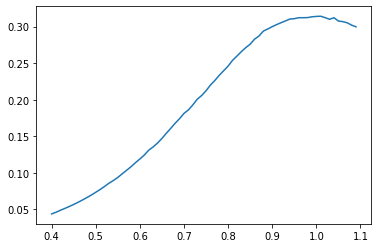

In [101]:
off_diag = cor_obs[np.triu_indices(NUM_FEATURES, k=1)]

F1_score_2 = []
precision_list_2 = []
recall_list_2 = []

threshold_list = np.arange(0.4, 1.1, 0.01)
    
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>target_signal)*1
    predict_positive_index = (np.abs(var_off_diag_3)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score_2 += [2*precision*recall/(precision+recall)]
    precision_list_2 += [precision]
    recall_list_2 += [recall]

    
print('Best F1 Score: ', np.max(F1_score_2))
plt.plot(threshold_list, F1_score_2)
plt.show()

In [97]:
max_F1_score_list_2 = []


for signal in signal_list:
    max_F1_score = 0
    for thres in np.arange(signal-0.1, signal+0.4, 0.01):
        positive_index = (np.abs(off_diag)>signal)
        predict_positive_index = (np.abs(var_off_diag_3)>thres)
        fn = np.sum(positive_index*(1-predict_positive_index))
        tp = np.sum(predict_positive_index*positive_index)

        precision = tp/np.sum(predict_positive_index)
        recall = tp/(tp+fn)

        ## Deviation from the true covariance matrix
        max_F1_score = max(max_F1_score, 2*precision*recall/(precision+recall))
    max_F1_score_list_2 += [max_F1_score]
    
with open('./gisette/results/max_F1_score_list(vanilla_CS).pickle', 'wb') as handle:
    pickle.dump(max_F1_score_list_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

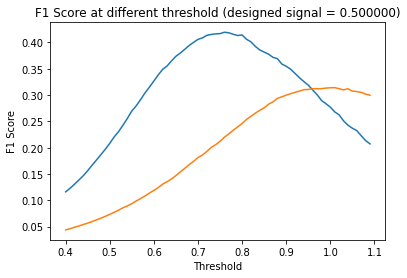

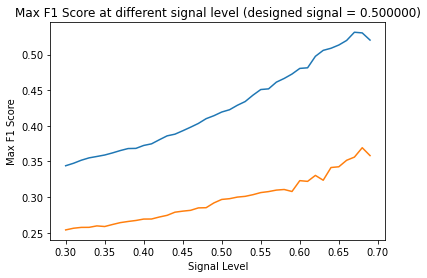

In [102]:
# threshold_list = np.arange(0.3, 1.1, 0.005)

plt.plot(threshold_list, F1_score, label = 'with sampling')
plt.plot(threshold_list, F1_score_2, label = 'without sampling')
plt.title('F1 Score at different threshold (designed signal = %f)' %target_signal)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('./Figures/Gisette/F1_score_using_different_thresholds(designed signal=%f).png' %target_signal)
plt.show()



plt.plot(signal_list, max_F1_score_list, label = 'with sampling')
plt.plot(signal_list, max_F1_score_list_2, label = 'without sampling')
plt.title('Max F1 Score at different signal level (designed signal = %f)' %target_signal)
plt.xlabel('Signal Level')
plt.ylabel('Max F1 Score')
plt.legend()
plt.savefig('./Figures/Gisette/Max_F1_score_at_different_signal_level(designed signal=%f).png' %target_signal)
plt.show()

## Summary plot

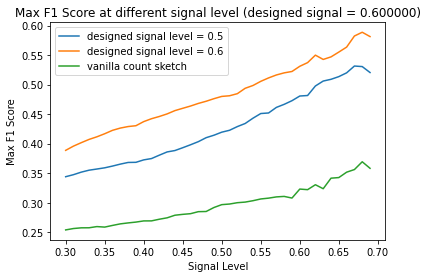

In [142]:
with open('./gisette/results/max_F1_score_list(designed signal=0.5).pickle', 'rb') as handle:
    max_F1_list_1 = pickle.load(handle)
    
with open('./gisette/results/max_F1_score_list(designed signal=0.6).pickle', 'rb') as handle:
    max_F1_list_2 = pickle.load(handle)
    
with open('./gisette/results/max_F1_score_list(vanilla_CS).pickle', 'rb') as handle:
    max_F1_list_3 = pickle.load(handle)
    
    

plt.plot(signal_list, max_F1_list_1, label = 'designed signal level = 0.5')
plt.plot(signal_list, max_F1_list_2, label = 'designed signal level = 0.6')
plt.plot(signal_list, max_F1_list_3, label = 'vanilla count sketch')
plt.title('Max F1 Score at different signal level (designed signal = %f)' %target_signal)
plt.xlabel('Signal Level')
plt.ylabel('Max F1 Score')
plt.legend()
plt.savefig('./Figures/Gisette/Max_F1_score_at_different_signal_level(designed signal=%f).png' %target_signal)
plt.show()